# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: Иванов Александр Вадимович

Группа:  MADE-DS-12

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [119]:
import geopandas as gpd
from shapely.geometry import Point
import random
import folium

m = folium.Map(min_zoom=2)
afghanistan = gpd.read_file('https://nominatim.openstreetmap.org/search?country=Afghanistan&polygon_geojson=1&format=geojson')

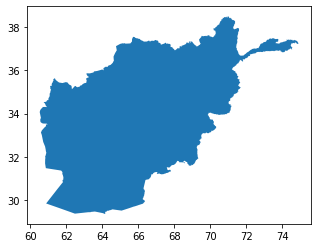

In [120]:
# проверим данные
afghanistan.plot()

In [125]:
def random_point():
    x = (1 - 2 * random.random()) * 180
    y = (1 - 2 * random.random()) * 90
    return [x, y]

In [126]:
folium.Circle(
    radius=100,
    location=random_point(),
    popup='The Waterfront',
    color='crimson',
    fill=False,
).add_to(m)

folium.Circle(
    radius=100,
    location=random_point(),
    popup='The Waterfront',
    color='crimson',
    fill=False,
).add_to(m)

m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [ ]:
# put your code here

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
# put your code here